# Preprocessing and loading in Data
The following cells define helper functions and combines the batch
files into a single dictionary that contains the images for each class 
as an numpy array (array of arrays).

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import _pickle as cPickle
from sklearn.decomposition import PCA
from scipy.spatial.distance import sqeuclidean
from __future__ import division

In [3]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo, encoding='latin-1')
    fo.close()
    return dict

In [4]:
#Function defined for testing purposes.
def display_image(sample_image):
    output = list()
    ratio = int(len(sample_image) / 3)

    red = sample_image[0:ratio]
    green = sample_image[ratio: 2*ratio]
    blue = sample_image[2*ratio:]

    for i in range(len(red)):
        val = list([red[i], green[i], blue[i]])
        output.append(val)

    output = np.array(output).reshape((32,32,3))

    #fig1 = plt.figure()
    #fig1.add_subplot(7,7,1)
    imgplot = plt.imshow(output, aspect='auto')

In [5]:
def cmdscale(D):
    """                 
    Source: http://www.nervouscomputer.com/hfs/cmdscale-in-python/
    
    Classical multidimensional scaling (MDS)                                                  
                                                                                               
    Parameters                                                                                
    ----------                                                                                
    D : (n, n) array                                                                          
        Symmetric distance matrix.                                                            
                                                                                               
    Returns                                                                                   
    -------                                                                                   
    Y : (n, p) array                                                                          
        Configuration matrix. Each column represents a dimension. Only the                    
        p dimensions corresponding to positive eigenvalues of B are returned.                 
        Note that each dimension is only determined up to an overall sign,                    
        corresponding to a reflection.                                                        
                                                                                               
    e : (n,) array                                                                            
        Eigenvalues of B.                                                                     
                                                                                               
    """
    # Number of points                                                                        
    n = len(D)
 
    # Centering matrix                                                                        
    H = np.eye(n) - np.ones((n, n))/n
 
    # YY^T                                                                                    
    B = -H.dot(D**2).dot(H)/2
 
    # Diagonalize                                                                             
    evals, evecs = np.linalg.eigh(B)
 
    # Sort by eigenvalue in descending order                                                  
    idx   = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:,idx]

    # Compute the coordinates using positive-eigenvalued components only                      
    w, = np.where(evals > 0)
    L  = np.diag(np.sqrt(evals[w]))
    V  = evecs[:,w]
    Y  = V.dot(L)

    return Y, evals

In [6]:
# Read the data into python
batches = list()
column_names = unpickle("data/batches.meta")
batches.append(unpickle("data/data_batch_1"))
batches.append(unpickle("data/data_batch_2"))
batches.append(unpickle("data/data_batch_3"))
batches.append(unpickle("data/data_batch_4"))
batches.append(unpickle("data/data_batch_5"))
batches.append(unpickle("data/test_batch"))

In [7]:
# Combine the different batches into one dataset.
label_names = column_names['label_names']
merged_data = dict()
for data_batch in batches:
    raw_data  = data_batch['data']
    labels = data_batch['labels']
    for i in range(len(raw_data)):
        label = label_names[labels[i]]
        if (label not in merged_data):
            merged_data[label] = list()
        merged_data[label].append(raw_data[i])



In [8]:
#Verifying that the data has been merged correctly, 
print(merged_data.keys())
c = np.array(merged_data['automobile'])
print(c.shape)

dict_keys(['frog', 'deer', 'cat', 'dog', 'truck', 'automobile', 'airplane', 'horse', 'ship', 'bird'])
(6000, 3072)


# Problem 4.10 Part A

In the problem below, we compute the mean image and the first twenty principal coordinates for each of the categories and store them into dictionaries. Afterwards, we computed the error for each of the image classes after applying PCA to the dataset. Both the squared error and the percentage of variance not explained by the twenty components were computed.

In [9]:
def comp_error(A, B):
    tot_err = 0
    for A_item, B_item in zip(A, B):
        tot_err += sqeuclidean(A_item, B_item)
    
    return tot_err

In [10]:
# Problem 4.10 Part A
errors_dict = dict()
var_err_dict = dict()
mean_image_dict = dict()
transformed_dict = dict()

for key in merged_data:
    # Gets the mean for the image class.
    item = np.array(merged_data[key], dtype=np.uint8)
    val = np.mean(item, axis=0, dtype=int)
    mean_image_dict[key] = val
    
    # Fits the data and applies dimensionality reduction on the data
    pca_data = item
    pca = PCA(n_components = 20)
    X_proj = pca.fit_transform(pca_data)
    cat_rest = pca.inverse_transform(X_proj)
    transformed_dict[key] = cat_rest
    
    # Compute the errors
    error = comp_error(item, cat_rest)
    var_err = 1 - sum(pca.explained_variance_ratio_)
    errors_dict[key] = error
    var_err_dict[key] = var_err
    


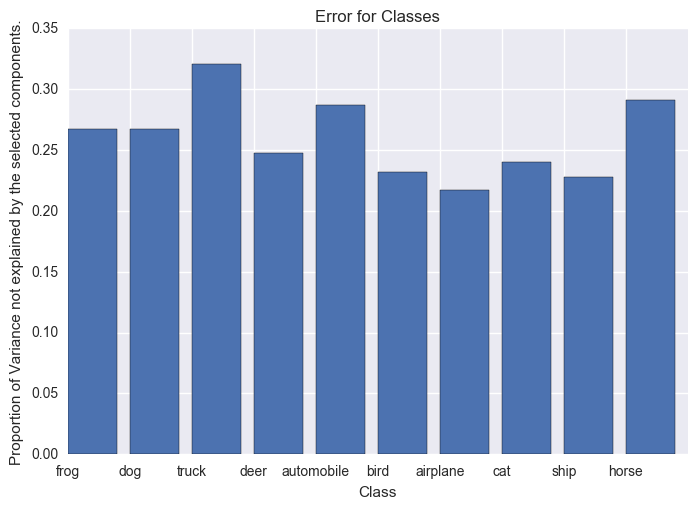

In [11]:
# Plot the values
plt.bar(range(len(var_err_dict)), var_err_dict.values())
plt.xticks(range(len(var_err_dict)), var_err_dict.keys())
plt.xlabel("Class")
plt.ylabel("Proportion of Variance not explained by the selected components.")
plt.title("Error for Classes")

plt.show()


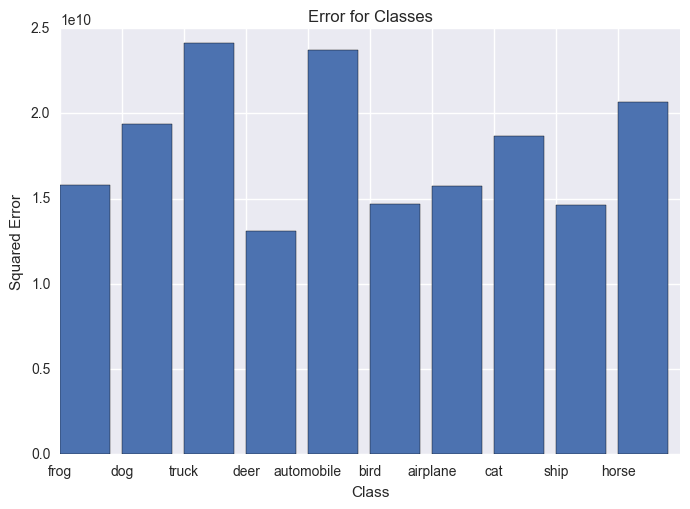

In [12]:
# Plot the values
plt.bar(range(len(errors_dict)), errors_dict.values())
plt.xticks(range(len(errors_dict)), errors_dict.keys())
plt.xlabel("Class")
plt.ylabel("Squared Error")
plt.title("Error for Classes")

plt.show()


# Problem 4.10 Part B
In this problem, for each class A and B, we computed the distances between the mean images calculate in Part A to make a 2D map of the means of each categories using PCoA. 

[]

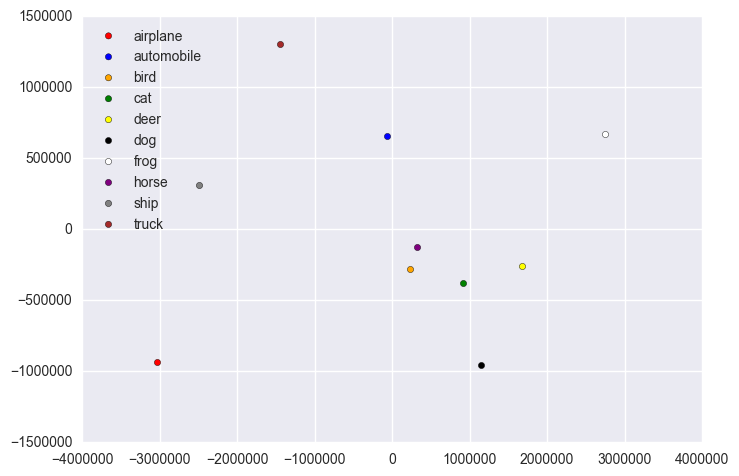

In [13]:
# Problem 4.10 Part B
keys = sorted(mean_image_dict.keys())

# Construct the distance matrix.
pair_distances = np.empty((10,10))
for i in range(10):
    for j in range(10):
        a = mean_image_dict[keys[i]]
        b = mean_image_dict[keys[j]]
        pair_distances[i][j] = sqeuclidean(a,b)

# Apply PCoA to the computed Distance Matrix and take the 2-D plots
coords = cmdscale(pair_distances)[0]

x_data = list()
y_data = list()

for i in coords:
    x_data.append(i[0])
    y_data.append(i[1])
    
fig, ax = plt.subplots()
labels = list()

col = ['Red', 'Blue', 'Orange', 'Green', 'Yellow', 'Black', 'White', 'Purple', 'Grey', 'Brown']

for i in range(len(keys)):
    labels.append(ax.scatter(x_data[i], y_data[i], c= col[i], label=keys[i]))

ax.legend(loc='upper left', handles = labels)
ax.plot()

# Problem 4.10 Part C
Here, we define two helper functions. e_func(A,B) computes the average error from obtained by representing all the images of class A using the mean image of class A and the principal components of class B. We apply it to the similarity function:

\begin{equation*}
(1/2)(E(A -> B) + E(B -> A))
\end{equation*}

The similarity matrix constructed is then passed in as a parameter to the PCoA function to construct another 2D map of the classes. The results are outlined below.

In [14]:
def e_func(A, B):
    # A is the mean of class A and B is the first 20 principal components of class B.
   
    A = mean_image_dict[A]
    B = transformed_dict[B]
    tot_sum = 0
    for row in B:
        tot_sum += sqeuclidean(A,row)
    
    return (tot_sum / len(A))

In [15]:
def similarity_A_B(a, b):
    e_a_b = e_func(a,b)
    e_b_a = e_func(b,a)
    return (1/2) * (e_a_b + e_b_a)

In [16]:
sim_matrix = np.empty([10,10])
for i in range(10):
    for j in range(10):
        a = keys[i]
        b = keys[j]
        
        sim_matrix[i][j] = similarity_A_B(a, b)
        


[]

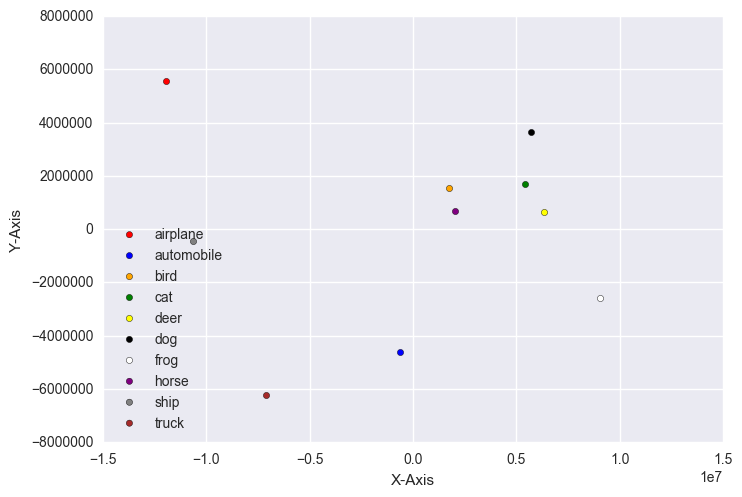

In [17]:
coords = cmdscale(sim_matrix)[0]

x_data = list()
y_data = list()

for i in coords:
    x_data.append(i[0])
    y_data.append(i[1])
    
fig, ax = plt.subplots()
labels = list()

col = ['Red', 'Blue', 'Orange', 'Green', 'Yellow', 'Black', 'White', 'Purple', 'Grey', 'Brown']

for i in range(len(keys)):
    labels.append(ax.scatter(x_data[i], y_data[i], c= col[i], label=keys[i], ))

ax.legend(loc='lower left', handles = labels)
ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis')
ax.plot()

# Analysis
The resulting graph is very similar to the one that was produced in part b. The reason that they are similar is that PCoA takes in an input matrix that describes the dissimilarities between a pair of objects. Both the distance matrix computed in Part B and the matrix computed in Part C reflect these requirements. Thus, it would follow that these measures of dissimilarities between classes would be yield similar results when performing PCoA. In other words, both methods picked up on "between-object" distances in the higher dimensional dataset.